<a href="https://colab.research.google.com/github/AleCava01/Synthesizing-the-Mind/blob/main/STM_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Dataset


In [20]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = [os.path.join(root_dir, f)
                            for f in os.listdir(root_dir)
                            if f.endswith('.png')]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("L")  # "L" = grayscale
        if self.transform:
            img = self.transform(img)
        return img


In [21]:
img_size = 182

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

dataset = CustomImageDataset(root_dir="drive/MyDrive/PACS/Synthesizing_the_mind/coronal_2D_healthy_IOP_scanner", transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


#Definizione del VAE

In [22]:
class VAE(nn.Module):
    def __init__(self, input_dim=img_size*img_size, hidden_dim=2048, latent_dim=64):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


## Loss function

In [23]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1000):
    model.train()
    train_loss = 0
    for data in dataloader:
        data = data.view(-1, img_size*img_size).to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        loss = loss_function(recon, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {train_loss / len(dataloader.dataset):.4f}")


Epoch 1, Loss: 24097.1389
Epoch 2, Loss: 22182.5220
Epoch 3, Loss: 22844.6030
Epoch 4, Loss: 22292.3032
Epoch 5, Loss: 18832.5051
Epoch 6, Loss: 18663.9599
Epoch 7, Loss: 17130.2688
Epoch 8, Loss: 16418.0568
Epoch 9, Loss: 16452.7846
Epoch 10, Loss: 17076.5560
Epoch 11, Loss: 18225.7542
Epoch 12, Loss: 16877.6679
Epoch 13, Loss: 16723.0190
Epoch 14, Loss: 16599.5750
Epoch 15, Loss: 16497.2962
Epoch 16, Loss: 16373.3594
Epoch 17, Loss: 16332.1432
Epoch 18, Loss: 16212.8497
Epoch 19, Loss: 16183.7139
Epoch 20, Loss: 16137.6286
Epoch 21, Loss: 16120.8910
Epoch 22, Loss: 16073.9540
Epoch 23, Loss: 16163.1757
Epoch 24, Loss: 16065.1968
Epoch 25, Loss: 15976.2713
Epoch 26, Loss: 15916.0633
Epoch 27, Loss: 15875.8334
Epoch 28, Loss: 15935.5255
Epoch 29, Loss: 16083.0494
Epoch 30, Loss: 16436.3357
Epoch 31, Loss: 16027.9065
Epoch 32, Loss: 16035.0021
Epoch 33, Loss: 16025.4029
Epoch 34, Loss: 15844.8376
Epoch 35, Loss: 15831.4797
Epoch 36, Loss: 15810.4749
Epoch 37, Loss: 15723.9198
Epoch 38, 

# Sampling

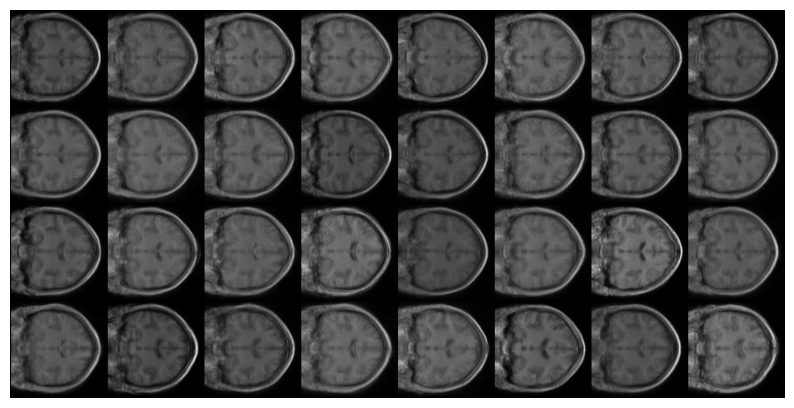

In [69]:
import torchvision
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    z = torch.randn(32, 64).to(device)
    samples = model.decode(z).cpu().view(-1, 1, img_size, img_size)
    grid = torchvision.utils.make_grid(samples, nrow=8)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()
